# THIS NOTEBOOK WAS USED FOR COLOR NORMALIZATION FOR THE WHOLE DATASET, IT IS NOT ANYMORE SO DON'T USE THIS IN THAT WAY <3

### Paths (you have to change this according to your own paths)

In [1]:
# FILL IN YOUR OWN PATHS WHERE THE test_stg1 AND train FOLDER ARE!
path_data_test = '../../Data/test_stg1'
path_data_train = '../../Data/train/train'
path_output = '../../Data' # Here the new folders will be created with colorized images

### Imports

In [2]:
import pandas as pd
import numpy as np
import scipy
import os
import glob
from sklearn import cluster
from scipy.misc import imread
import skimage.measure as sm
import cv2
import multiprocessing
from tqdm import *
import random
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (20, 12)
import seaborn as sns
new_style = {'grid': False}
plt.rc('axes', **new_style)

### Functions



In [81]:
# Function to do histogram matching
def get_histogram_matching_lut(h_input, h_template):
    ''' h_input: histogram to transfrom, h_template: reference'''
    if len(h_input) != len(h_template):
        print 'histograms length mismatch!'
        return False
    
    # Create cumulative sum histograms
    H_input = np.cumsum(h_input)
    H_template = np.cumsum(h_template)

    # Create empty LUT and fill (linear time)
    LUT = []
    for i in range(0, len(H_template)):
        for j in range(len(LUT), len(H_input)):
            
            # As long as the input value is not at the template value, match their index with the template index
            if (H_template[i] >= H_input[j]):
                LUT += [i]
            else:
                # Assure minimal distance is the criterium
                #if ( abs(H_template[i] - H_input[j]) < abs(H_template[i+1] - H_input[j])):
                    #LUT += [i]
                break
    
    LUT = np.asarray(LUT) # Turns list into array to match future code
    
    return LUT,H_input,H_template

# Function to normalize color between images
def stain_normalization(input_img, target_img, n_bins=255):
    """ Stain normalization based on histogram matching. """
    input_img = input_img/255.0
    target_img = target_img/255.0

    normalized_img = np.zeros_like(input_img)
    for i in [0, 1, 2]:
        hist_input = np.histogram(input_img[:, :, i], bins=np.linspace(0., 1., n_bins+1))
        hist_target = np.histogram(target_img[:, :, i], bins=np.linspace(0., 1., n_bins+1))
        LUT, _, _ = get_histogram_matching_lut(hist_input[0], hist_target[0])
    
        stain_lut = LUT[(input_img[:, :, i] * (n_bins-1)).astype(int)].astype(float) / float(n_bins)
        normalized_img[:, :, i] = stain_lut
    
    
    return normalized_img

# Function to normalize color between images
def save_histogram(target_img, n_bins=255):
    """ Stain normalization based on histogram matching. """
    target_img = target_img/255.0
    norm_histogram = np.zeros((3,255))    
    for i in [0, 1, 2]:
        hist_target = np.histogram(target_img[:, :, i], bins=np.linspace(0., 1., n_bins+1))    
        norm_histogram[i] = hist_target[0]
    
    np.savetxt('../../Data/Plaatjes/histogram_img_07419.txt',norm_histogram)
    
# Function to normalize color between images
def stain_normalization_with_hist(target_hist, input_img, n_bins=255):
    """ Stain normalization based on histogram matching. """
    input_img = input_img/255.0

    normalized_img = np.zeros_like(input_img)
    for i in [0, 1, 2]:
        hist_input = np.histogram(input_img[:, :, i], bins=np.linspace(0., 1., n_bins+1))
        LUT, _, _ = get_histogram_matching_lut(hist_input[0], target_hist[i])
    
        stain_lut = LUT[(input_img[:, :, i] * (n_bins-1)).astype(int)].astype(float) / float(n_bins)
        normalized_img[:, :, i] = stain_lut

    return normalized_img

### Input data, colorize and save to disk

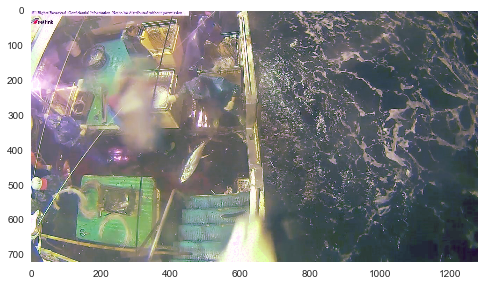

In [82]:
# Image to be used as base colorization
color_img = np.asarray(Image.open(path_data_test + '/img_07419.jpg'))
color_img = cv2.resize(color_img, (1280,720))
test_img = np.asarray(Image.open(path_data_test + '/img_00027.jpg'))
test_img = cv2.resize(test_img, (1280,720))
save_histogram(color_img)
check = np.loadtxt('../../Data/Plaatjes/histogram_img_07419.txt')
norm_img = stain_normalization_with_hist(check, test_img)
plt.imshow(norm_img)

In [ ]:
##########################
# Test Data loading Test #
##########################

new_dir_test = path_output + '/test_stg1_color/'
if(not(os.path.exists(new_dir_test))):
    os.mkdir(new_dir_test)

# Code for testing small sets
# select = 10 # Only load 100 images for speed
# test_path = path_data_test + '/*.jpg'
# test_files = sorted(glob.glob(test_path), key=lambda x: random.random())[:select]
# test = np.array([imread(img) for img in test_files])
# names_test = []
# for f in test_files:
#     name = os.path.basename(f)
#     names_test.append(name)    
    
# Use all data
print("Converting the test set")
test_path = path_data_test + '/*.jpg'
for img in glob.glob(test_path):
    name = os.path.basename(img)
    test = cv2.imread(img)
    test = cv2.resize(test, (1280,720))
    test_color = stain_normalization(test, color_img)
    path = new_dir_test + name
    scipy.misc.imsave(path, test_color)

######################    
# Train Data loading #
######################

folders = ['/ALB', '/BET', '/DOL', '/LAG', '/Nof', '/OTHER', '/SHARK', '/YFT']
if(not(os.path.exists(path_output + '/train_color'))):
    os.mkdir(path_output + '/train_color')
    
for i in range(len(folders)):
    
# Code for testing small sets
#     select = 10 # Only load 100 images for speed
#     train_path = path_data_train + folders[i] + '/*.jpg'
#     train_files = sorted(glob.glob(test_path), key=lambda x: random.random())[:select]
#     train = np.array([imread(img) for img in train_files])
#     names_train = []
#     for f in train_files:
#         name = os.path.basename(f)
#         names_train.append(name)

# Use all data
    new_dir_train = path_output + '/train_color' + folders[i]
    if(not(os.path.exists(new_dir_train))):
        os.mkdir(new_dir_train)
    
    print("Converting the " + folders[i] + " train set")
    
    train_path = path_data_train + folders[i] + '/*.jpg'
    for img in glob.glob(train_path):
        name = os.path.basename(img)
        train = cv2.imread(img)
        train = cv2.resize(train, (1280,720))
        train_color = stain_normalization(train, color_img)
        path = new_dir_train + '/' + name
        scipy.misc.imsave(path, train_color)